requirements:
* pandas
* tables (pip)

In [1]:
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import column_accumulator
import coffea.processor as processor

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import pandas as pd

from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters

In [2]:
import os
import json
from os.path import join

dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e.json')))

In [4]:
dataset={
    '4mu/mXX-100_mA-5': dict(files=dataset4mu_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '4mu/mXX-1000_mA-0p25': dict(files=dataset4mu_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-100_mA-5': dict(files=dataset2mu2e_['mXX-100_mA-5'], treename='ffNtuplizer/ffNtuple'),
    '2mu2e/mXX-1000_mA-0p25': dict(files=dataset2mu2e_['mXX-1000_mA-0p25'], treename='ffNtuplizer/ffNtuple'),
}

In [48]:
class LeptonJetsFeatureHarvester(processor.ProcessorABC):
    def __init__(self):
        
        self._accumulator = processor.dict_accumulator({
            'pt': column_accumulator(np.zeros(shape=(0,))),
            'eta': column_accumulator(np.zeros(shape=(0,))),
            'nef': column_accumulator(np.zeros(shape=(0,))),
            'maxd0': column_accumulator(np.zeros(shape=(0,))),
            'mind0': column_accumulator(np.zeros(shape=(0,))),
            'tkiso': column_accumulator(np.zeros(shape=(0,))),
            'pfiso': column_accumulator(np.zeros(shape=(0,))),
            'spreadpt': column_accumulator(np.zeros(shape=(0,))),
            'spreaddr': column_accumulator(np.zeros(shape=(0,))),
            'lamb': column_accumulator(np.zeros(shape=(0,))),
            'epsi': column_accumulator(np.zeros(shape=(0,))),
            'ecfe1': column_accumulator(np.zeros(shape=(0,))),
            'ecfe2': column_accumulator(np.zeros(shape=(0,))),
            'ecfe3': column_accumulator(np.zeros(shape=(0,))),
            'label': column_accumulator(np.zeros(shape=(0,))),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        absd0 = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0)
        maxd0_ = absd0.max()
        mind0_ = absd0.min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets = leptonjets[metfiltermask&triggermask]
        matchmask  = matchmask[metfiltermask&triggermask]
        
        output['pt']       += column_accumulator(leptonjets.pt.flatten())
        output['eta']      += column_accumulator(leptonjets.eta.flatten())
        output['nef']      += column_accumulator(leptonjets.nef.flatten())
        output['maxd0']    += column_accumulator(leptonjets.maxd0.flatten())
        output['mind0']    += column_accumulator(leptonjets.mind0.flatten())
        output['tkiso']    += column_accumulator(leptonjets.tkiso.flatten())
        output['pfiso']    += column_accumulator(leptonjets.pfiso.flatten())
        output['spreadpt'] += column_accumulator(leptonjets.spreadpt.flatten())
        output['spreaddr'] += column_accumulator(leptonjets.spreaddr.flatten())
        output['lamb']     += column_accumulator(leptonjets.lamb.flatten())
        output['epsi']     += column_accumulator(leptonjets.epsi.flatten())
        output['ecfe1']    += column_accumulator(leptonjets.ecf1.flatten())
        output['ecfe2']    += column_accumulator(leptonjets.ecf2.flatten())
        output['ecfe3']    += column_accumulator(leptonjets.ecf3.flatten())
#         output['label']    += column_accumulator(matchmask.flatten())
        output['label']    += column_accumulator(leptonjets.pt.zeros_like().flatten() )
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [49]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsFeatureHarvester(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/20 [00:00<?, ?items/s]

[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0 0.0]]
[[0.0] [0.0 0.0 0.0] [0.0] ... [0.0] [0.0] [0.0 0.0]]
[[0.0] [0.0 0.0] [0.0] ... [0.0 0.0 0.0] [0.0] [0.0]]
[[0.0] [0.0 0.0] [0.0] ... [0.0 0.0] [0.0 0.0] [0.0]]
[[0.0] [0.0 0.0] [0.0 0.0] ... [0.0] [0.0] [0.0]]
[[0.0 0.0] [0.0 0.0] [0.0] ... [0.0] [0.0] [0.0]]
[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0]]


Processing:   5%|▌         | 1/20 [00:01<00:19,  1.00s/items]

[[0.0] [0.0] [0.0] ... [0.0 0.0] [0.0] [0.0]]
[[0.0 0.0] [0.0] [0.0 0.0] ... [0.0 0.0] [0.0] [0.0 0.0]]
[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0]]
[[0.0] [0.0] [0.0] ... [0.0 0.0] [0.0] [0.0]]
[[0.0] [0.0] [0.0] ... [0.0 0.0 0.0 0.0] [0.0] [0.0 0.0]]
[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0 0.0]]
[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0]]
[[0.0] [0.0] [0.0 0.0] ... [0.0] [0.0] [0.0]]
[[0.0 0.0] [0.0] [0.0] ... [0.0 0.0] [0.0 0.0] [0.0]]
[[0.0] [0.0] [0.0] ... [0.0] [0.0 0.0] [0.0 0.0]]


Processing:  40%|████      | 8/20 [00:02<00:08,  1.34items/s]

[[0.0] [0.0] [0.0] ... [0.0] [0.0] [0.0]]
[[0.0] [0.0 0.0] [0.0] ... [0.0 0.0] [0.0] [0.0]]
[[0.0] [0.0 0.0] [0.0] ... [0.0] [0.0 0.0] [0.0]]


Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


In [8]:
ca = column_accumulator(np.zeros(shape=(0,)))
ca += column_accumulator(np.arange(10))
ca += column_accumulator(np.arange(4))
ca

column_accumulator(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 1., 2., 3.]))

In [18]:
for k in output:
    print(k, output[k].value.size)

pt 14773
eta 14773
nef 14773
maxd0 14773
mind0 14773
tkiso 14773
pfiso 14773
spreadpt 14773
spreaddr 14773
lamb 14773
epsi 14773
ecfe1 14773
ecfe2 14773
ecfe3 14773
label 14773


In [24]:
df = pd.DataFrame({k: v.value for k, v in output.items()})

In [27]:
df.tail()

,pt,eta,nef,maxd0,mind0,tkiso,pfiso,spreadpt,spreaddr,lamb,epsi,ecfe1,ecfe2,ecfe3,label
14768,118.126472,1.960011,0.002384,0.129009,0.0,0.007918,0.035799,0.705627,6.995951e-06,-6.172760,0.002379,118.129150,23.374399,NaN,1.0
14769,368.946533,-0.092170,0.004056,10.140939,0.0,0.028789,0.051829,0.896396,1.008290e-04,-6.937321,0.001054,369.073547,1016.413086,117.190231,1.0
14770,122.791893,0.479021,1.000000,0.000000,0.0,1.000000,0.620454,0.977546,6.158105e-06,-4.554620,0.010825,122.797569,29.497808,NaN,1.0
14771,314.265381,-0.922868,0.007559,1.056591,0.0,0.058203,0.061970,0.727448,5.469191e-05,-6.787814,0.000971,314.323669,548.029785,75.078560,1.0
14772,298.424042,0.848743,1.000000,0.000000,0.0,1.000000,0.159644,0.997870,2.660818e-07,-6.157111,0.001952,298.428162,NaN,NaN,1.0


In [32]:
df.to_hdf('selectedsignal.h5', key='df')

In [4]:
df = pd.read_hdf('selectedsignal.h5', 'df').fillna(0)
df.tail()

,pt,eta,nef,maxd0,mind0,tkiso,pfiso,spreadpt,spreaddr,lamb,epsi,ecfe1,ecfe2,ecfe3,label
14768,118.126472,1.960011,0.002384,0.129009,0.0,0.007918,0.035799,0.705627,6.995951e-06,-6.172760,0.002379,118.129150,23.374399,0.000000,1.0
14769,368.946533,-0.092170,0.004056,10.140939,0.0,0.028789,0.051829,0.896396,1.008290e-04,-6.937321,0.001054,369.073547,1016.413086,117.190231,1.0
14770,122.791893,0.479021,1.000000,0.000000,0.0,1.000000,0.620454,0.977546,6.158105e-06,-4.554620,0.010825,122.797569,29.497808,0.000000,1.0
14771,314.265381,-0.922868,0.007559,1.056591,0.0,0.058203,0.061970,0.727448,5.469191e-05,-6.787814,0.000971,314.323669,548.029785,75.078560,1.0
14772,298.424042,0.848743,1.000000,0.000000,0.0,1.000000,0.159644,0.997870,2.660818e-07,-6.157111,0.001952,298.428162,0.000000,0.000000,1.0


In [7]:
leptonJets_notrack = df[df['nef']>0.999]
leptonJets_tracked = df[df['nef']<=0.999]

In [8]:
print(len(leptonJets_notrack.index))
print(len(leptonJets_tracked.index))

4957
9816


In [5]:
dsource = join(os.getenv('FH_BASE'), 'FireHydrant/BDT/xgbgarage/190724/1/xgbpredictions.h5')
testdf = pd.read_hdf(dsource, 'test')
traindf = pd.read_hdf(dsource, 'train')

In [56]:
from coffea import hist
dataset_axis = hist.Cat('dataset', 'train/test')
label_axis = hist.Cat('label', 'S/B')
bdt_axis = hist.Bin('score', 'BDT score', 20, -2.5, 2.5)


default = hist.Hist("norm. counts", dataset_axis, label_axis, bdt_axis)
default.fill(dataset='test', label='signal (test)', score=testdf.query('y==1')['default'].values)
default.fill(dataset='test', label='background (test)', score=testdf.query('y==0')['default'].values)
default.fill(dataset='train', label='signal (train)', score=traindf.query('y==1')['default'].values)
default.fill(dataset='train', label='background (train)', score=traindf.query('y==0')['default'].values)

optimized = hist.Hist("norm. counts", dataset_axis, label_axis, bdt_axis)
optimized.fill(dataset='test', label='signal (test)', score=testdf.query('y==1')['optimized'].values)
optimized.fill(dataset='test', label='background (test)', score=testdf.query('y==0')['optimized'].values)
optimized.fill(dataset='train', label='signal (train)', score=traindf.query('y==1')['optimized'].values)
optimized.fill(dataset='train', label='background (train)', score=traindf.query('y==0')['optimized'].values)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [48]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    #'color':'k',
    'elinewidth': 1,
    'emarker': '_',
    'markeredgecolor': 'k'
}
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}

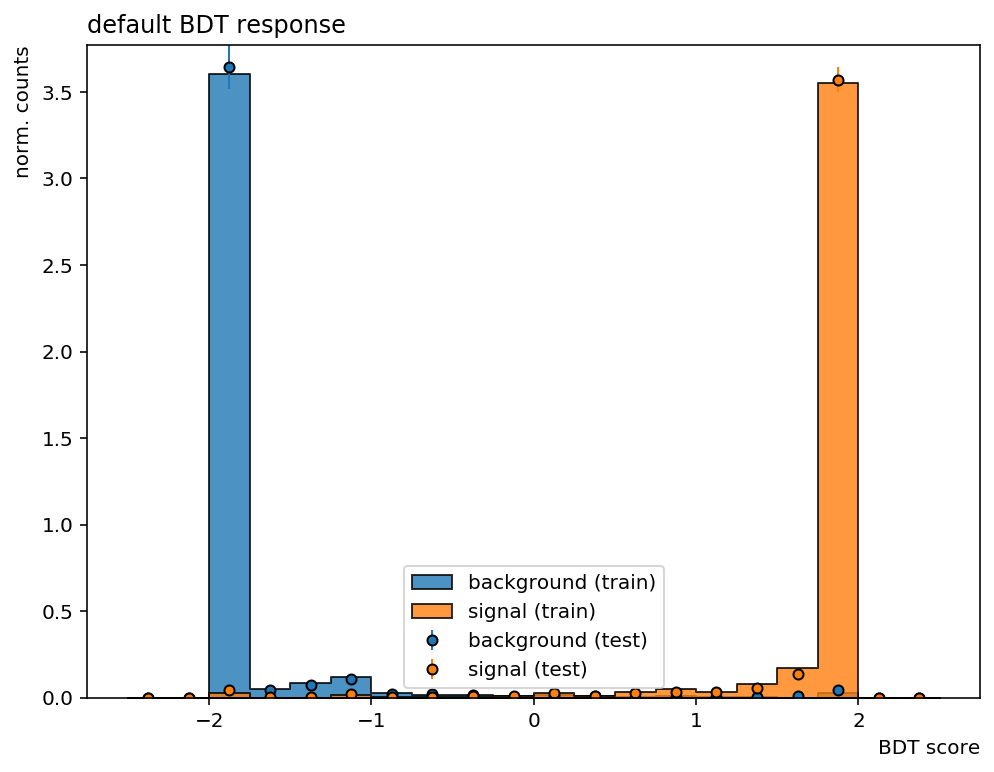

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(default.project('dataset', 'test'), overlay='label', ax=ax, density=True, clear=False, error_opts=data_err_opts)
hist.plot1d(default.project('dataset', 'train'), overlay='label', ax=ax, line_opts=None, clear=False, density=True, fill_opts=fill_opts)
ax.legend()
# ax.set_yscale('log')
ax.autoscale(axis='y', tight=True)
ax.set_ylim(0, None);
ax.set_title('default BDT response', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

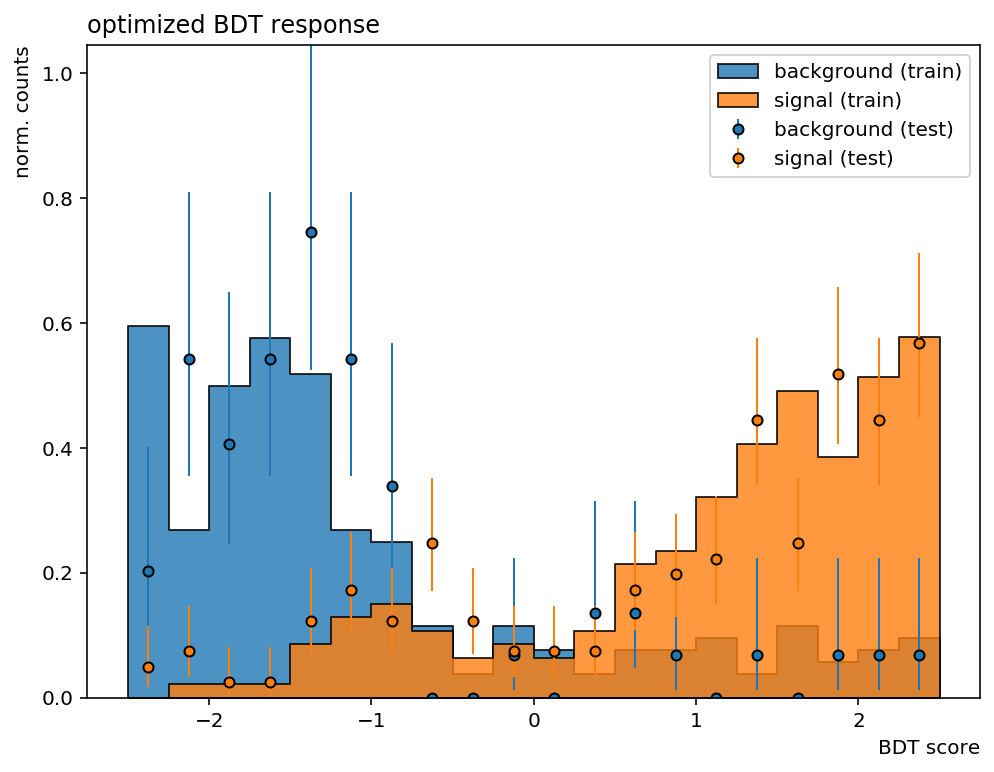

In [58]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(optimized.project('dataset', 'test'), overlay='label', ax=ax, density=True, clear=False, error_opts=data_err_opts)
hist.plot1d(optimized.project('dataset', 'train'), overlay='label', ax=ax, line_opts=None, clear=False, density=True, fill_opts=fill_opts)
ax.legend()
# ax.set_yscale('log')
ax.autoscale(axis='y', tight=True)
ax.set_ylim(0, None);
ax.set_title('optimized BDT response', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [4]:
import xgboost as xgb

trainingdata = '../trainingdata.h5'
key = 'df'
trainoutdir = join(os.getenv('FH_BASE'), 'FireHydrant/BDT/xgbgarage/190725/2')

df = pd.read_hdf(trainingdata, key)
featurecols = [x for x in df.columns if x != 'label']
dfull = xgb.DMatrix(df[featurecols].values, label=df['label'])

xgbm_default = xgb.Booster({"nthread": 12})
xgbm_default.load_model(join(trainoutdir, "model_default/model.bin"))
preds_default = xgbm_default.predict(dfull)

xgbm_optimized = xgb.Booster({"nthread": 12})
xgbm_optimized.load_model(join(trainoutdir, "model_optimized/model.bin"))

preds_optimized = xgbm_optimized.predict(dfull)

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(array([ 153520., 1198230., 1168371.,  531658.,  198579.,   95950.,
          96666.,  113843.,  133349.,   38704.]),
 array([-11.121447 ,  -9.0233135,  -6.9251795,  -4.827046 ,  -2.7289124,
         -0.6307788,   1.4673548,   3.5654883,   5.663622 ,   7.7617555,
          9.859889 ], dtype=float32),
 <a list of 10 Patch objects>)

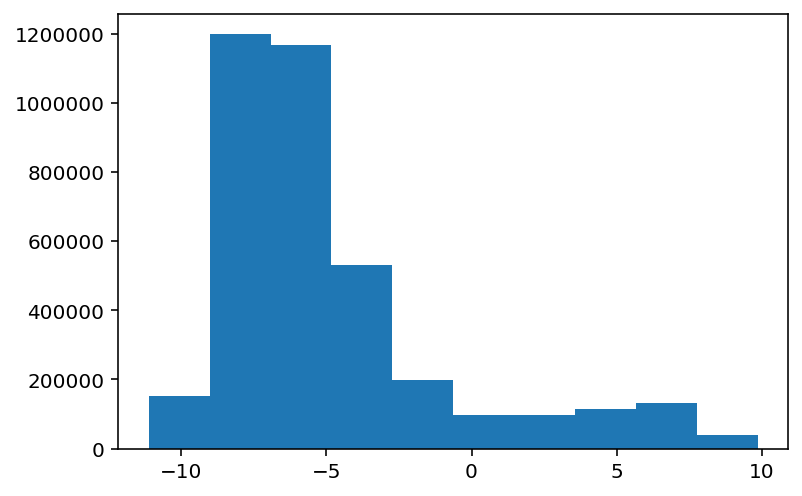

In [5]:
plt.hist(preds_optimized)

In [8]:
from coffea import hist
label_axis = hist.Cat('label', 'S/B')
bdt_axis = hist.Bin('score', 'BDT score', 50, -10, 10)

default = hist.Hist("norm. counts", label_axis, bdt_axis)
default.fill(label='signal', score=preds_default[df['label'].values.astype(bool)])
default.fill(label='background', score=preds_default[~df['label'].values.astype(bool)])
optimized = hist.Hist("norm. counts", label_axis, bdt_axis)
optimized.fill(label='signal', score=preds_optimized[df['label'].values.astype(bool)])
optimized.fill(label='background', score=preds_optimized[~df['label'].values.astype(bool)])

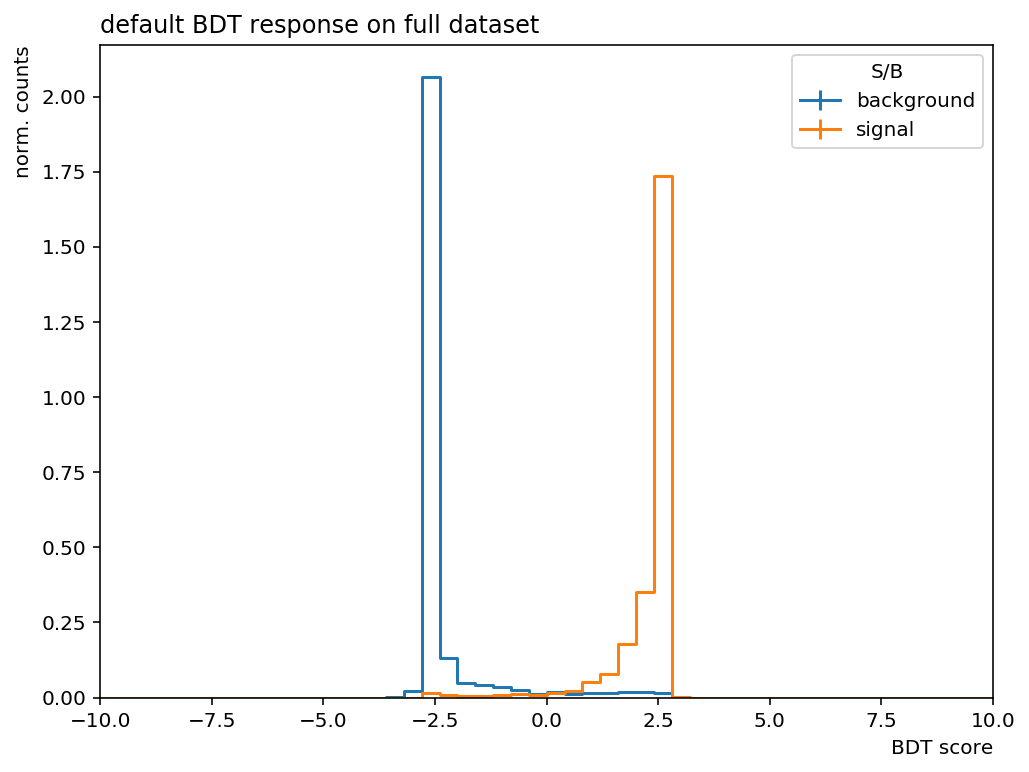

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(default, overlay='label', ax=ax, density=True)
ax.set_ylim(0, None);
ax.set_title('default BDT response on full dataset', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

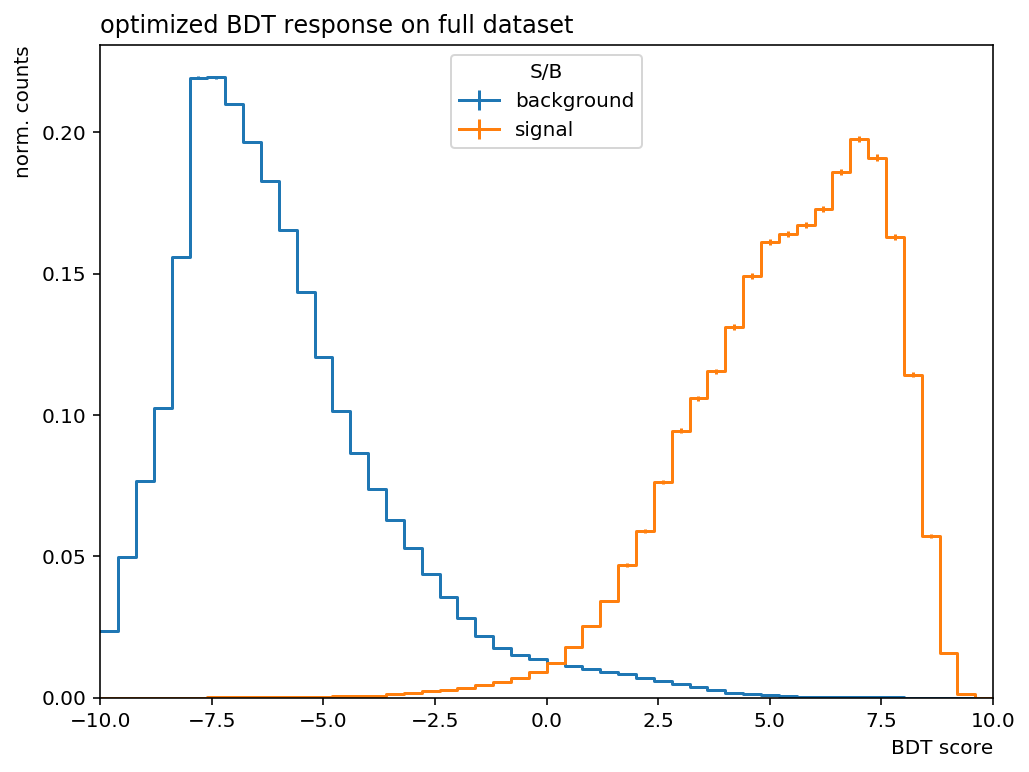

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(optimized, overlay='label', ax=ax, density=True)
ax.set_ylim(0, None);
ax.set_title('optimized BDT response on full dataset', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

using optimized, separte tracked/notracked

In [11]:
df0 = df.query("nef>0.999") # notrack
df1 = df.query("nef<=0.999")# tracked
d0 = xgb.DMatrix(df0[featurecols].values, label=df0['label'])
d1 = xgb.DMatrix(df1[featurecols].values, label=df1['label'])

preds0 = xgbm_optimized.predict(d0)
preds1 = xgbm_optimized.predict(d1)

In [12]:
h0 = hist.Hist("norm. counts", label_axis, bdt_axis)
h0.fill(label='signal', score=preds0[df0['label'].values.astype(bool)])
h0.fill(label='background', score=preds0[~df0['label'].values.astype(bool)])

h1 = hist.Hist("norm. counts", label_axis, bdt_axis)
h1.fill(label='signal', score=preds1[df1['label'].values.astype(bool)])
h1.fill(label='background', score=preds1[~df1['label'].values.astype(bool)])

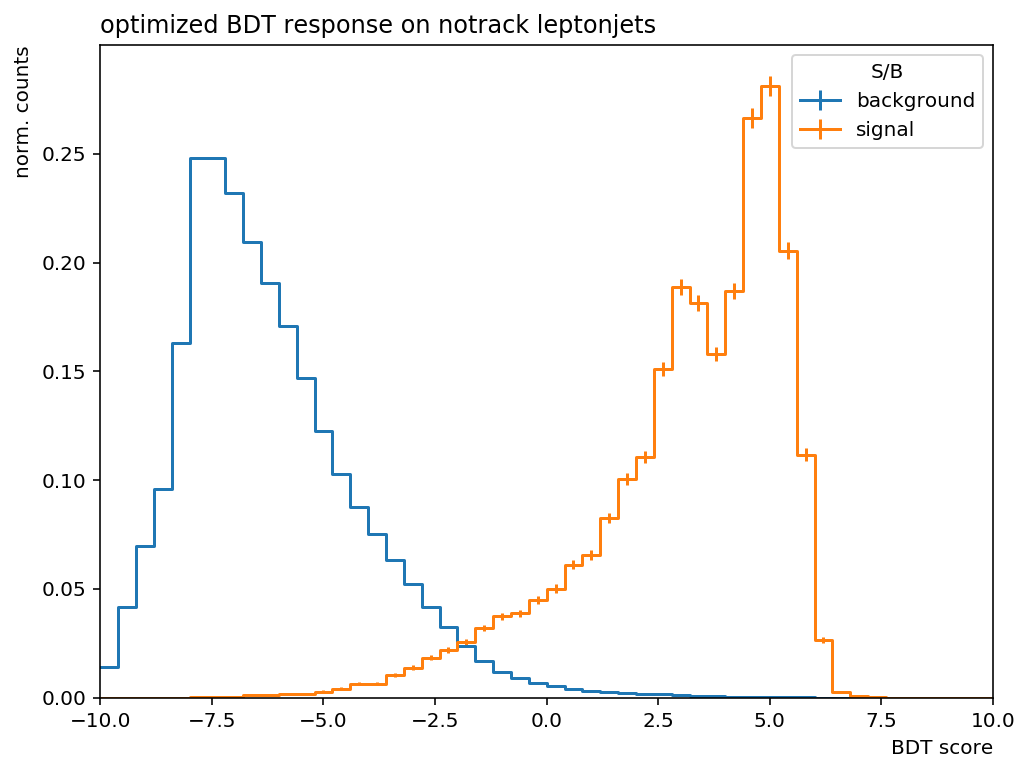

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(h0, overlay='label', ax=ax, density=True)
ax.set_ylim(0, None);
ax.set_title('optimized BDT response on notrack leptonjets', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

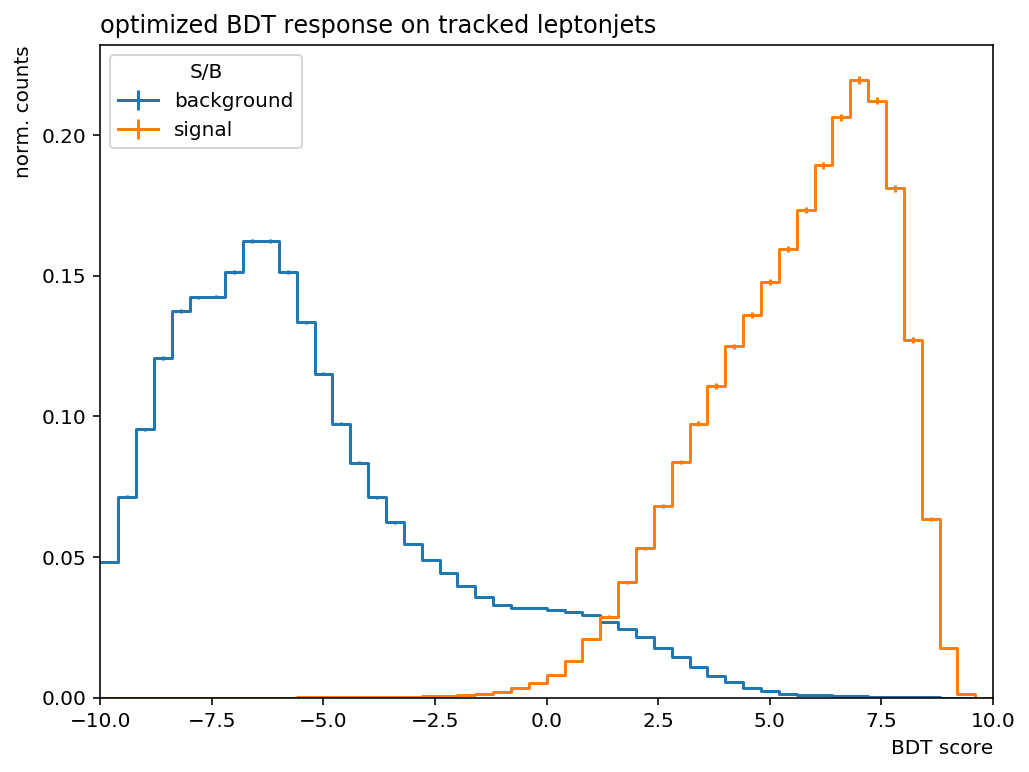

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(h1, overlay='label', ax=ax, density=True)
ax.set_ylim(0, None);
ax.set_title('optimized BDT response on tracked leptonjets', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

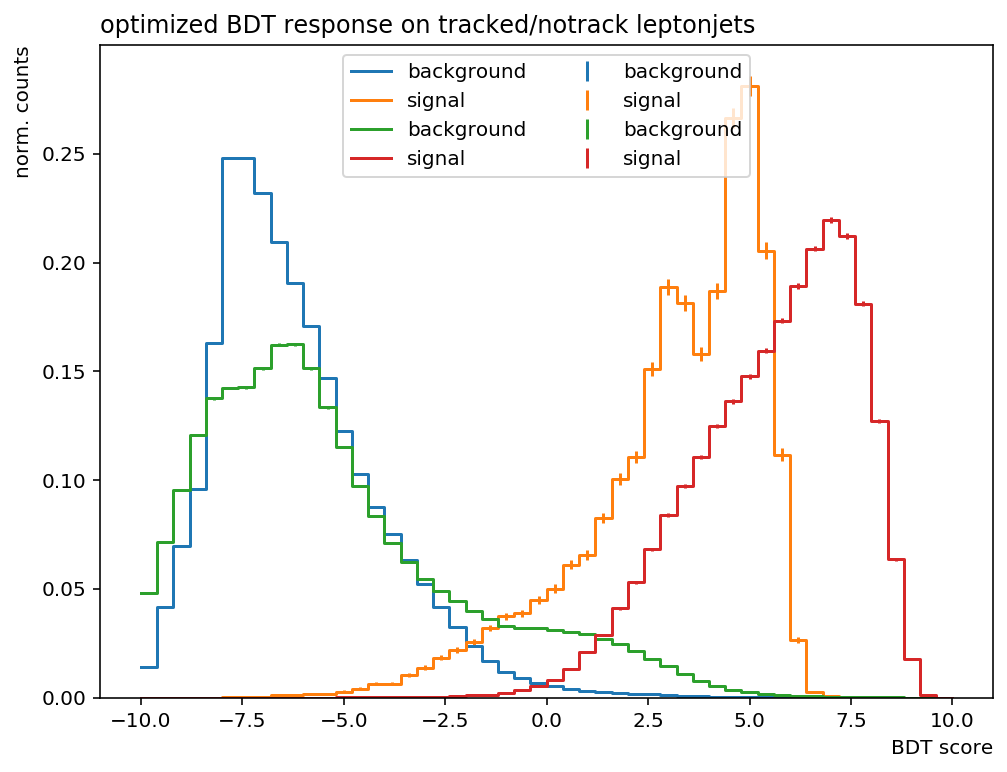

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(h0, overlay='label', ax=ax, density=True, clear=False)
hist.plot1d(h1, overlay='label', ax=ax, density=True, clear=False)
ax.set_ylim(0, None)
ax.legend(ncol=2)
ax.set_title('optimized BDT response on tracked/notrack leptonjets', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");